/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 7525.5063 - mae: 68.6636 - val_loss: 2803.9421 - val_mae: 39.8941
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 1527.4474 - mae: 28.8450 - val_loss: 2230.6614 - val_mae: 35.6866
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 1327.7964 - mae: 26.2292 - val_loss: 2124.6067 - val_mae: 35.0583
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1271.7201 - mae: 25.6420 - val_loss: 2738.2302 - val_mae: 37.6675
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 1320.7638 - mae: 25.9858 - val_loss: 2050.9045 - val_mae: 34.7542
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 1177.2378 - mae: 24.2787 - val_loss: 1921.8190 - val_mae: 32.3506
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1090.9247 - mae: 23.2371 - val_loss: 2810.1248 - val_mae: 37.3826
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 962.6122 - mae: 21.6233 - val_loss: 1332.5

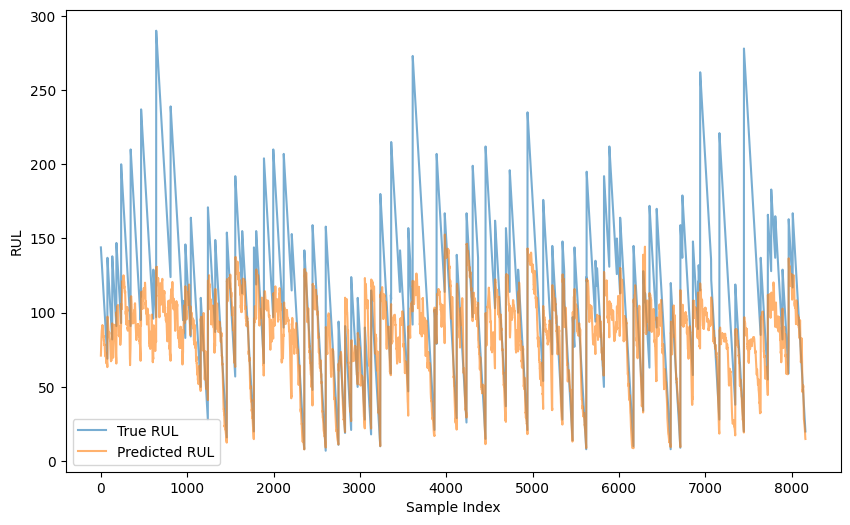

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load NASA C-MAPSS FD001 dataset
train_data = pd.read_csv("/kaggle/input/cmaps-data/train_FD001.txt", sep='\s+', header=None)
test_data = pd.read_csv("/kaggle/input/cmaps-data/test_FD001.txt", sep='\s+', header=None)
rul_data = pd.read_csv("/kaggle/input/cmaps-data/RUL_FD001.txt", sep='\s+', header=None)

# Define column names based on the dataset documentation
columns = ['unit_number', 'time_in_cycles'] + [f'op_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_measurement_{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns

# Add RUL to the training data
max_cycles = train_data.groupby('unit_number')['time_in_cycles'].max()
train_data['RUL'] = train_data.apply(lambda x: max_cycles[x['unit_number']] - x['time_in_cycles'], axis=1)

# Add RUL to test data
test_data['RUL'] = 0
for i, unit in enumerate(test_data['unit_number'].unique()):
    max_cycle = test_data[test_data['unit_number'] == unit]['time_in_cycles'].max()
    test_data.loc[test_data['unit_number'] == unit, 'RUL'] = rul_data.iloc[i, 0] + max_cycle - \
                                                            test_data.loc[test_data['unit_number'] == unit, 'time_in_cycles']

# Preprocess sensor data
feature_cols = [col for col in train_data.columns if 'sensor_measurement' in col]
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data[feature_cols])
scaled_test_data = scaler.transform(test_data[feature_cols])

# Combine scaled data with unit_number and RUL
train_data_combined = np.hstack((train_data[['unit_number']].values, scaled_train_data, train_data[['RUL']].values))
test_data_combined = np.hstack((test_data[['unit_number']].values, scaled_test_data, test_data[['RUL']].values))

# Prepare sequence data
def create_sequences(data, sequence_length=50):
    X, y = [], []
    for unit in np.unique(data[:, 0]):  # Loop over each engine unit
        unit_data = data[data[:, 0] == unit]  # Select data for a specific engine unit
        for i in range(len(unit_data) - sequence_length):
            X.append(unit_data[i:i + sequence_length, 1:-1])  # Exclude unit_number and RUL
            y.append(unit_data[i + sequence_length, -1])  # Corresponding RUL
    return np.array(X), np.array(y)

sequence_length = 50
X_train, y_train = create_sequences(train_data_combined, sequence_length)
X_test, y_test = create_sequences(test_data_combined, sequence_length)

# Build LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    Dense(1)  # Predict RUL
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict RUL
predictions = model.predict(X_test)

# Plot predictions vs. true RUL
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True RUL', alpha=0.6)
plt.plot(predictions, label='Predicted RUL', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.show()
